In [551]:
%cd ~/code/projects/nn-play/

import keras 
from keras.models import Model, Sequential
from keras.layers import Input, Dense
from keras.optimizers import Adam, Adadelta, RMSprop, SGD
from keras.layers import Input, Dense, Convolution2D, Deconvolution2D, MaxPooling2D,\
    UpSampling2D, Merge, LSTM, Flatten, ZeroPadding2D, Reshape, BatchNormalization, Dropout
from keras.layers.wrappers import TimeDistributed

from simple_container import DataContainer

import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/home/ira/code/projects/nn-play


In [726]:
IM_WIDTH = 28
IM_HEIGHT = 28
IM_CHANNELS = 1

SERIES_SHIFT = 1
EP_LEN = 40 + SERIES_SHIFT
BATCH_SIZE = 32

V_SIZE = 512

In [727]:
# autoencoder

input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
h = Convolution2D(16, 5, 5, subsample=(2,2), activation='relu', border_mode='same')(input_im)
h = Convolution2D(8, 3, 3, subsample=(2,2), activation='relu', border_mode='same')(h)
h = Flatten()(h)
h = Dense(V_SIZE, activation='relu')(h)
h = Dense(8*7*7, activation='relu')(h)
h = Reshape((7,7,8))(h)
h = UpSampling2D((2,2))(h)
h = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(h)
h = UpSampling2D((2,2))(h)
output_im = Convolution2D(1, 5, 5, activation='relu', border_mode='same')(h)

m = Model(input_im, output_im)
m.compile(optimizer=Adam(lr=0.0002), loss='mse')
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_28 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_43 (Convolution2D) (None, 14, 14, 16)    416         input_28[0][0]                   
____________________________________________________________________________________________________
convolution2d_44 (Convolution2D) (None, 7, 7, 8)       1160        convolution2d_43[0][0]           
____________________________________________________________________________________________________
flatten_14 (Flatten)             (None, 392)           0           convolution2d_44[0][0]           
___________________________________________________________________________________________

In [728]:
input_im = Input(shape=(10, 16))
h = TimeDistributed(Dense(8), input_shape=(10, 64))(input_im)
m = Model(input_im, h)
# m.compile(optimizer=Adam(lr=0.0002), loss='mse')
m.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_29 (InputLayer)            (None, 10, 16)        0                                            
____________________________________________________________________________________________________
timedistributed_36 (TimeDistribu (None, 10, 8)         136         input_29[0][0]                   
Total params: 136
Trainable params: 136
Non-trainable params: 0
____________________________________________________________________________________________________


In [729]:
# predictive ae

input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
h = Convolution2D(16, 5, 5, subsample=(2,2), activation='relu', border_mode='same')(input_im)
h = Convolution2D(8, 3, 3, subsample=(2,2), activation='relu', border_mode='same')(h)
h = Flatten()(h)
v = Dense(V_SIZE, activation='relu')(h)

enc = Model(input_im, v)
enc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_30 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
convolution2d_47 (Convolution2D) (None, 14, 14, 16)    416         input_30[0][0]                   
____________________________________________________________________________________________________
convolution2d_48 (Convolution2D) (None, 7, 7, 8)       1160        convolution2d_47[0][0]           
____________________________________________________________________________________________________
flatten_15 (Flatten)             (None, 392)           0           convolution2d_48[0][0]           
___________________________________________________________________________________________

 38%|███▊      | 190/500 [00:30<00:48,  6.33it/s]

In [730]:
input_v = Input(shape=(V_SIZE,))

h = Dense(8*7*7, activation='relu')(input_v)
h = Reshape((7,7,8))(h)
h = UpSampling2D((2,2))(h)
h = Convolution2D(16, 3, 3, activation='relu', border_mode='same')(h)
h = UpSampling2D((2,2))(h)
output_im = Convolution2D(1, 5, 5, activation='relu', border_mode='same')(h)

# output_im

dec = Model(input_v, output_im)
dec.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_31 (InputLayer)            (None, 512)           0                                            
____________________________________________________________________________________________________
dense_38 (Dense)                 (None, 392)           201096      input_31[0][0]                   
____________________________________________________________________________________________________
reshape_11 (Reshape)             (None, 7, 7, 8)       0           dense_38[0][0]                   
____________________________________________________________________________________________________
upsampling2d_19 (UpSampling2D)   (None, 14, 14, 8)     0           reshape_11[0][0]                 
___________________________________________________________________________________________

In [731]:
input_im = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
v = enc(input_im)
output_im = dec(v)

ae = Model(input_im, output_im)
ae.summary()
ae.compile(optimizer=Adam(lr=0.0002), loss='mse')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_32 (InputLayer)            (None, 28, 28, 1)     0                                            
____________________________________________________________________________________________________
model_19 (Model)                 (None, 512)           202792      input_32[0][0]                   
____________________________________________________________________________________________________
model_20 (Model)                 (None, 28, 28, 1)     202665      model_19[1][0]                   
Total params: 405,457
Trainable params: 405,457
Non-trainable params: 0
____________________________________________________________________________________________________


In [739]:
pred_ae = Sequential()
pred_ae.add(TimeDistributed(enc, input_shape=((EP_LEN-SERIES_SHIFT, IM_WIDTH, IM_HEIGHT, IM_CHANNELS))))
pred_ae.add(LSTM(V_SIZE, input_shape=(EP_LEN, V_SIZE), return_sequences=True))

# pred_ae.add(dec)
pred_ae.add(TimeDistributed(dec, input_shape=((EP_LEN, V_SIZE))))

# pred_ae.add(TimeDistributed(LSTM(V_SIZE), input_shape=((EP_LEN, IM_WIDTH, IM_HEIGHT, IM_CHANNELS))))

# input_series = Input(shape=(IM_WIDTH, IM_HEIGHT, IM_CHANNELS))
# v_series = TimeDistributed(enc(input_series), input_shape=((EP_LEN, IM_WIDTH, IM_HEIGHT, IM_CHANNELS)))




# predae = Model(input_series, v_series)
pred_ae.summary()
pred_ae.compile(optimizer=Adam(lr=0.0002), loss='mse')


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
timedistributed_39 (TimeDistribu (None, 40, 512)       202792      timedistributed_input_19[0][0]   
____________________________________________________________________________________________________
lstm_27 (LSTM)                   (None, 40, 512)       2099200     timedistributed_39[0][0]         
____________________________________________________________________________________________________
timedistributed_40 (TimeDistribu (None, 40, 28, 28, 1) 202665      lstm_27[0][0]                    
Total params: 2,504,657
Trainable params: 2,504,657
Non-trainable params: 0
____________________________________________________________________________________________________


In [733]:
# data_train = DataContainer('data-toy/single-train.pt', batch_size=128)
data_train = DataContainer('data-balls/balls-train.pt', batch_size=32,
                          ep_len_read=EP_LEN)
# data_valid = DataContainer('data-toy/single-valid.pt', batch_size=128)
data_valid = DataContainer('data-balls/balls-valid.pt', batch_size=32,
                          ep_len_read=EP_LEN)


In [760]:
for i in tqdm.tqdm(range(500)):
    x = data_train.get_n_random_episodes(32)
    pred_ae.train_on_batch(x[:,0:-SERIES_SHIFT,...], x[:,SERIES_SHIFT:,...])

100%|██████████| 500/500 [00:45<00:00, 10.88it/s]


In [761]:
x = data_valid.get_n_random_episodes(32)
pred_ae.train_on_batch(x[:,0:-SERIES_SHIFT,...], x[:,SERIES_SHIFT:,...])

0.012215158

In [762]:
x = data_valid.get_n_random_episodes(32)
y = pred_ae.predict(x[:,0:-SERIES_SHIFT,...])
i = SERIES_SHIFT

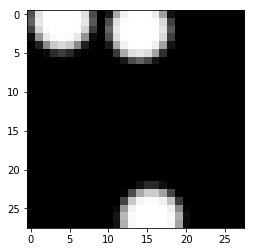

In [763]:
plt.imshow(x[0,i,:,:,0], cmap='gray')

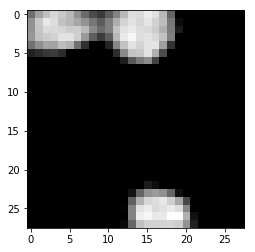

In [764]:
plt.imshow(y[0,i-SERIES_SHIFT,:,:,0], cmap='gray')
i += 1

In [65]:
x = data_train.get_batch_images().reshape((32, 28, 28, 1))
y = ae.predict(x)
i = 0

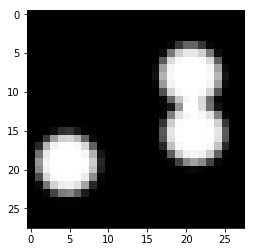

In [66]:
plt.imshow(x[i,:,:,0], cmap='gray')

TypeError: Invalid dimensions for image data

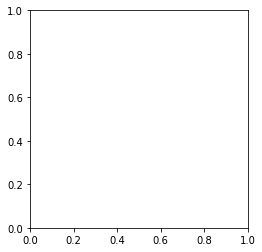

In [288]:
plt.imshow(y[i,:,:,0], cmap='gray')
i += 1